## BATTLE OF THE SOLAR POWER PLANTS

#### Introduction:
Pakistan' peak electricity demand is estimated at 25,000 MW while its total power generation capacity is 28,000 MWs. Pakistan meets two-thirds of its energy requirement from fuel oil and natural gas. The share of renewables in Pakistan's energy mix is around 5% only. 
In November 2019 the Government of Pakistan unveiled its new Renewable Energy Development Policy. The policy aims to increase the share of renewables in Pakistan's energy mix by 30%. Around 8,000MW cheap renewable clean and green energy will be added to the system by 2025 while it will be increased to 20,000MW by 2030.
In order to meet the goals stated in this policy, Pakistan will have to invest heavily in Solar and Wind energy plants. This will not be possible without Utility-Scale Soalr Projects. In this study we will try to determin the best places in Pakistan for setting up a solar Independent Power Plant (Solar IPP) which will provide better electricity output at optimized CAPEX.


#### Problem:
Like with all major utility scale projects, transmission cost and transmission losses are a major bottleneck in a project's feasibility. Pakistan's regions which receive very high Direct Normal Irradiation (DNI) of above 6 kWh/m2/day are very distant from the national power grid. Which means developing a solar IPP in one of those regions will have huge transmission costs.
In order to overcome this problem I have decided to chose sites which are nearest to existing power stations.
Another major factor in developing a Solar IPP is the cost of Land. The nearer the IPP site is to a city or a major population center the higher will be the cost of land and there will also be difficulties in acquiring a single plot of land for the IPP.




#### Data: 
The World Bank Group has worked extensively on Pakistan's electricity transmission grid data. A GEOJSON file listing all nodes in the national grid is available at their website https://energydata.info/dataset/pakistan-electricity-transmission-network-2017 I have used that data in this study. There are a lot of un-named entries in the data set which I cleaned to get the locations of the grid stations.
Then I by using the Foursuare API I explored venues nearby the grid stations. The purpose was to explore how many venues are there within a range of 15 kms of the Grid Station and how what was the mean distance of those venues from the Grid locations. Greater the number of venues near a grid and smaller mean distance of those venues from the Grid Location would mean that the Grid station is in an urban area and land development costs would be much higher.
Finally I use the Global Solar Atlas website https://globalsolaratlas.info/map?c=30.637912,68.994141,5&r=PAK to get the Specific photovoltaic power output (PVOUT) values of the grid locations. This results in a dataframe with coordinates of all grid locations, their nearby venues count, mean distances from the venues and the Specific photovoltaic power output (PVOUT) values for each location. Now we can run the K-means clustering algorithm to cluster the grid nodes and label them to find out the most appropriate grid nodes for the development of a Solar IPP.

1. Lets Start by importing the required Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import json
import pandas as pd
import geojson
import geojsonio

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


2. Lets import the GEOJSON file with the grid coordinates 

In [2]:
with open('PTN.geojson', 'r') as f:
    network_data = json.load(f)


In [3]:
power_network=network_data['features']

In [4]:
power_network[0]

{'type': 'Feature',
 'properties': {'osm_id': '391735667',
  'name': None,
  'highway': None,
  'waterway': None,
  'aerialway': None,
  'barrier': None,
  'man_made': None,
  'z_order': 0,
  'other_tags': '"power"=>"minor_line"'},
 'geometry': {'type': 'LineString',
  'coordinates': [[69.2585449, 27.8930252],
   [69.2594248, 27.8929274],
   [69.2605895, 27.8927981],
   [69.2615646, 27.8926427]]}}

In [5]:
# define the dataframe columns
column_names = ['Node name', 'Description','Node type', 'Latitude', 'Longitude'] 

# instantiate the dataframe
PTN = pd.DataFrame(columns=column_names)

In [6]:
PTN


Empty DataFrame
Columns: [Node name, Description, Node type, Latitude, Longitude]
Index: []

3. Now lets read the data from GEOJSON file to our Dataframe

In [7]:
for data in power_network:
    name = data['properties']['name'] 
    description = data['properties']['other_tags']
        
    network_type = data['geometry']['type']
    network_latlon = data['geometry']['coordinates'][0]
    network_lat = network_latlon[1]
    network_lon = network_latlon[0]
    
    PTN = PTN.append({'Node name': name,
                                          'Description': description,
                                          'Node type':network_type,
                                          'Latitude': network_lat,
                                          'Longitude': network_lon}, ignore_index=True)

In [8]:
PTN.head()

Node name  \
0                         None   
1                         None   
2  Fauji Kabirwala Power Plant   
3                         None   
4                         None   

                                         Description   Node type   Latitude  \
0                              "power"=>"minor_line"  LineString  27.893025   
1  "power"=>"line","cables"=>"6","voltage"=>"500000"  LineString  30.099509   
2  "power"=>"plant","operator"=>"Fauji Kabirwala ...  LineString  30.523032   
3                              "power"=>"minor_line"  LineString  27.889868   
4                                    "power"=>"line"  LineString  30.523050   

   Longitude  
0  69.258545  
1  71.166414  
2  71.956962  
3  69.264215  
4  71.957151

4. Lets analyze the 'Node types'

In [9]:
PTN.groupby('Node type').count()

Node name  Description  Latitude  Longitude
Node type                                              
LineString        120         1001      1001       1001

In [10]:
#As all datapoints are 'LineString' we can drop the entire column from our DF
PTN=PTN.drop('Node type', axis=1)

In [11]:
PTN

Node name  \
0                                    None   
1                                    None   
2             Fauji Kabirwala Power Plant   
3                                    None   
4                                    None   
5                               Rohri New   
6                                    None   
7                                    None   
8                                    None   
9                                    None   
10                                   None   
11                                   None   
12                                   None   
13                                   None   
14                      Japan Power Plant   
15          Southern Electric Power Plant   
16                                   None   
17                                   None   
18                                   None   
19                                   None   
20                                   None   
21                                   None   
22                                   None   
23                                   None   
24                           Bannu 132 KV   
25                                   None   
26                                   None   
27                                   None   
28                                   None   
29                                   None   
30                                   None   
31                                   None   
32                                   None   
33                                   None   
34                                   None   
35                                   None   
36                                   None   
37                                   None   
38                                   None   
39                                   None   
40                                   None   
41                                   None   
42                                   None   
43                                   None   
44                                   None   
45                                 Multan   
46                                   None   
47                                   None   
48                                   None   
49                                   None   
50                                   None   
51                                   None   
52                                   None   
53                   Power Station Rousch   
54                                Loralai   
55                                   None   
56                                   None   
57                                   None   
58                                   None   
59                                   None   
60                                   None   
61                                   None   
62                                Sialkot   
63                                   None   
64                                   None   
65                                   None   
66                      Sitara Energy Ltd   
67                                   None   
68                                   None   
69                                   None   
70                                   None   
71                                   None   
72                                   None   
73             Bhikki Thermal Power Plant   
74                                   None   
75                               New Dadu   
76                                   None   
77                                   None   
78                                   None   
79                                   None   
80                           Grid Station   
81                                   None   
82                                   None   
83                                   None   
84                                   None   
85                                   None   
86                                   None   
87                                   None   
88                         

In [12]:
# Since we only required grid station locations which have a 'Node name', we are going to delete rows with no 'Node name' which 
#are mostly cables and powerlines

PTN=PTN.dropna(how='any',axis=0)
PTN=PTN.reset_index()

In [13]:
PTN=PTN.drop('index',axis=1)
PTN.shape

(120, 4)

In [14]:
PTN=PTN.sort_values(by=['Node name']).reset_index().drop('index', axis=1)


In [15]:
PTN

Node name  \
0                                   11KV   
1               500 KV Transmission line   
2                      AES Lalpir 362 MW   
3            AES Pak Gen Oil Power Plant   
4                 Anoud Power Generation   
5                      Atlas Power Plant   
6      Attock Generation Oil Power Plant   
7                                 BROTHA   
8                            Bahria Town   
9                    Balloki Power Plant   
10                                 Bannu   
11                          Bannu 132 KV   
12            Bhikki Thermal Power Plant   
13                            Bijli Ghar   
14                 Bin Qasim Power Plant   
15                                Burhan   
16                             Charsadda   
17              Crescent Power Tech Ltd.   
18                             D.G. Khan   
19                               Daharki   
20                             Daud Khel   
21         Engro Energy CCGT Power Plant   
22     FWEL-I / Mirpur Sakro Power House   
23           Fauji Kabirwala Power Plant   
24              Foundation Power Company   
25                    GEPCO Grid Station   
26                                Garden   
27                                 Gatti   
28                            Ghazi Road   
29                          Grid Station   
30              Grid Station 66 KV FESCO   
31                                 Guddu   
32                 Guddu Thermal Station   
33      Gul Ahmed Energy Oil Power Plant   
34                             Hala Road   
35             Hubco Narowal Power Plant   
36                     Hubco Power Plant   
37                    IESCO Grid Station   
38                              Jamshoro   
39          Jamshoro Thermal Power Plant   
40                     Japan Power Plant   
41           Jhimpir Wind Energy Project   
42                    Jinnah Power House   
43                      Johal Power line   
44                              K.D.A-33   
45                            KANUPP 2&3   
46                              KANUPP-1   
47          KESC Korangi Gas Power Plant   
48              KESC Korangi Power Plant   
49             KESC SITE Gas Power Plant   
50                         Kapco 1638 MW   
51                              Kassowal   
52         Khan Khwar Hydropower Project   
53                               Khuzdar   
54                  Kohinoor Power Plant   
55                  Kot Addu Power Plant   
56                    LESCO Grid Station   
57                    LESCO Grid Station   
58                                Lahore   
59               Lakhra Coal Power Plant   
60                  Lalpir Power Limited   
61                            Lalsohanra   
62                               Loralai   
63                                 MEPCO   
64                                 MEPCO   
65                            Mangla Dam   
66                                Mardan   
67                             Master 01   
68                                Multan   
69                          Muzaffargarh   
70                                 N.K.I   
71                              New Dadu   
72                       New Kot Lakhpat   
73                  Nishat Power Limited   
74                                 Okara   
75                                   P G   
76                              PESHAWAR   
77                     Pasni Power House   
78                              Peshawar   
79                    Power Grid Station   
80           Power House (North Karachi)   
81                         Power Station   
82                  Power Station Rousch   
83                            Power line   
84        Quaid-e-Azam Solar Power Plant   
85                                Quetta   
86                             REWAT New   
87                             Rohri New   
88                      Saba Power Plant   
89                               Sahiwal   
90                    Saif 

5. Now lets view the Grid Locations on a map using Folium

In [16]:
#Lets get the coordinates of Pakistan using geolocator
address = 'Islamabad, PK'

geolocator = Nominatim(user_agent="pk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Pakistan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Pakistan are 33.6938118, 73.0651511.


In [17]:
# Lets create map of Pakistan using latitude and longitude values and mark the locations of the Grid stations
map_PTN = folium.Map(location=[latitude,longitude], zoom_start=6)

# add markers to map
for lat, lng, label in zip(PTN['Latitude'], PTN['Longitude'], PTN['Node name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_PTN)  
    
map_PTN

6. Now lets use the Foursquare API to get the nearby venues for a single Grid Node e.g IESCO Grid Station

In [18]:
CLIENT_ID = 'TQ0EQVSWEW1PZSVXLNC0CPJ1QEXZIYAAH1GGUVKU4IOWS4GP' # your Foursquare ID
CLIENT_SECRET = 'WOAR3RL51SFCKQZ0QZKQ2YVQIUHXXWLAABMAAOC5NZL4USGN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TQ0EQVSWEW1PZSVXLNC0CPJ1QEXZIYAAH1GGUVKU4IOWS4GP
CLIENT_SECRET:WOAR3RL51SFCKQZ0QZKQ2YVQIUHXXWLAABMAAOC5NZL4USGN


In [19]:
index=PTN[PTN['Node name']=='IESCO Grid Station'].index
index

Int64Index([37], dtype='int64')

In [20]:
Grid_Lat=PTN.loc[37,'Latitude']
Grid_Lng=PTN.loc[37,'Longitude']
print('Coordinates of IESCO Grid Station:',Grid_Lat,Grid_Lng)


Coordinates of IESCO Grid Station: 33.643352 73.1551129


In [21]:
LIMIT=100
radius=5000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            Grid_Lat, 
            Grid_Lng, 
            radius, 
            LIMIT)

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eea17a3668a7c209c6c7a6c'},
 'response': {'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 33.688352045000045,
    'lng': 73.20906593469677},
   'sw': {'lat': 33.598351954999956, 'lng': 73.10115986530325}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c4170d8520fa5930babc9ac',
       'name': 'Chak Shahzad Farm',
       'location': {'lat': 33.666764441893285,
        'lng': 73.14201087328,
        'labeledLatLngs': [{'label': 'display',
          'lat': 33.666764441893285,
          'lng': 73.14201087328}],
        'distance': 2875,
        'cc': 'PK',
        'country': 'پاکستان',
        'formattedAd

In [23]:
results['response']['groups'][0]['items']

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4c4170d8520fa5930babc9ac',
   'name': 'Chak Shahzad Farm',
   'location': {'lat': 33.666764441893285,
    'lng': 73.14201087328,
    'labeledLatLngs': [{'label': 'display',
      'lat': 33.666764441893285,
      'lng': 73.14201087328}],
    'distance': 2875,
    'cc': 'PK',
    'country': 'پاکستان',
    'formattedAddress': ['پاکستان']},
   'categories': [{'id': '4bf58dd8d48988d15b941735',
     'name': 'Farm',
     'pluralName': 'Farms',
     'shortName': 'Farm',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/farm_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-4c4170d8520fa5930babc9ac-0'},
 {'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionR

In [24]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

C:\Users\Shamozai\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [25]:
nearby_venues

referralId  reasons.count  \
0  e-0-4c4170d8520fa5930babc9ac-0              0   
1  e-0-5023c2e4e4b02f139f6b7150-1              0   
2  e-0-50866bfde4b046720b27550d-2              0   
3  e-0-4fb7901ae4b0f61106403d3e-3              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   
3  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id         venue.name  venue.location.lat  \
0  4c4170d8520fa5930babc9ac  Chak Shahzad Farm           33.666764   
1  5023c2e4e4b02f139f6b7150             Avalon           33.644365   
2  50866bfde4b046720b27550d        Neela Sandu           33.642816   
3  4fb7901ae4b0f61106403d3e         Rawal Lake           33.656043   

   venue.location.lng                      venue.location.labeledLatLngs  \
0           73.142011  [{'label': 'display', 'lat': 33.66676444189328...   
1           73.105544  [{'label': 'display', 'lat': 33.64436479918493...   
2           73.204144  [{'label': 'display', 'lat': 33.6428164836779,...   
3           73.107060  [{'label': 'display', 'lat': 33.65604334540509...   

   venue.location.distance venue.location.cc venue.location.country  \
0                     2875                PK                پاکستان   
1                     4595                PK                پاکستان   
2                     4544                PK                پاکستان   
3                     4671                PK                پاکستان   

      venue.location.formattedAddress  \
0                           [پاکستان]   
1               [اسلام آباد, پاکستان]   
2  [Talhaar, Islambad-44000, پاکستان]   
3                           [پاکستان]   

                                    venue.categories  venue.photos.count  \
0  [{'id': '4bf58dd8d48988d15b941735', 'name': 'F...                   0   
1  [{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...                   0   
2  [{'id': '4bf58dd8d48988d1e4941735', 'name': 'C...                   0   
3  [{'id': '4bf58dd8d48988d161941735', 'name': 'L...                   0   

  venue.photos.groups venue.location.city         venue.location.state  \
0                  []                 NaN                          NaN   
1                  []          اسلام آباد  Islāmābād Capital Territory   
2                  []            Islambad                          NaN   
3                  []                 NaN                          NaN   

  venue.location.address venue.location.postalCode  
0                    NaN                       NaN  
1                    NaN                       NaN  
2                Talhaar                     44000  
3                    NaN                       NaN

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

name  categories        lat        lng  distance
0  Chak Shahzad Farm        Farm  33.666764  73.142011      2875
1             Avalon  Restaurant  33.644365  73.105544      4595
2        Neela Sandu  Campground  33.642816  73.204144      4544
3         Rawal Lake        Lake  33.656043  73.107060      4671

Excellent! The results give us the number of venues surrounding the grid location, and the distance of each venue from it
6. Now lets do this for all Grid Nodes

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=15000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Node name', 
                  'Node Latitude', 
                  'Node Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue distance',
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
# We will call this PTN_venues (PTN Stands for Pakistan Transmission Network)
PTN_venues = getNearbyVenues(names=PTN['Node name'],
                                   latitudes=PTN['Latitude'],
                                   longitudes=PTN['Longitude']                                
                                      )

In [31]:
PTN_venues

Node name  Node Latitude  Node Longitude  \
0                                    11KV      33.014250       70.699914   
1                500 KV Transmission line      28.430650       69.692011   
2                500 KV Transmission line      28.430650       69.692011   
3                       AES Lalpir 362 MW      30.098233       71.162417   
4                       AES Lalpir 362 MW      30.098233       71.162417   
5                       AES Lalpir 362 MW      30.098233       71.162417   
6                       AES Lalpir 362 MW      30.098233       71.162417   
7             AES Pak Gen Oil Power Plant      30.175593       70.925320   
8                  Anoud Power Generation      24.846694       67.131269   
9                  Anoud Power Generation      24.846694       67.131269   
10                 Anoud Power Generation      24.846694       67.131269   
11                 Anoud Power Generation      24.846694       67.131269   
12                 Anoud Power Generation      24.846694       67.131269   
13                 Anoud Power Generation      24.846694       67.131269   
14                 Anoud Power Generation      24.846694       67.131269   
15                 Anoud Power Generation      24.846694       67.131269   
16                 Anoud Power Generation      24.846694       67.131269   
17                 Anoud Power Generation      24.846694       67.131269   
18                 Anoud Power Generation      24.846694       67.131269   
19                 Anoud Power Generation      24.846694       67.131269   
20                 Anoud Power Generation      24.846694       67.131269   
21                 Anoud Power Generation      24.846694       67.131269   
22                 Anoud Power Generation      24.846694       67.131269   
23                 Anoud Power Generation      24.846694       67.131269   
24                 Anoud Power Generation      24.846694       67.131269   
25                 Anoud Power Generation      24.846694       67.131269   
26                 Anoud Power Generation      24.846694       67.131269   
27                 Anoud Power Generation      24.846694       67.131269   
28                 Anoud Power Generation      24.846694       67.131269   
29                 Anoud Power Generation      24.846694       67.131269   
30                 Anoud Power Generation      24.846694       67.131269   
31                 Anoud Power Generation      24.846694       67.131269   
32                 Anoud Power Generation      24.846694       67.131269   
33                 Anoud Power Generation      24.846694       67.131269   
34                 Anoud Power Generation      24.846694       67.131269   
35                 Anoud Power Generation      24.846694       67.131269   
36                 Anoud Power Generation      24.846694       67.131269   
37                 Anoud Power Generation      24.846694       67.131269   
38                 Anoud Power Generation      24.846694       67.131269   
39                 Anoud Power Generation      24.846694       67.131269   
40                 Anoud Power Generation      24.846694       67.131269   
41                 Anoud Power Generation      24.846694       67.131269   
42                 Anoud Power Generation      24.846694       67.131269   
43                 Anoud Power Generation      24.846694       67.131269   
44                 Anoud Power Generation      24.846694       67.131269   
45                 Anoud Power Generation      24.846694       67.131269   
46                 Anoud Power Generation      24.846694       67.131269   
47                 Anoud Power Generation      24.846694       67.131269   
48                 Anoud Power Generation      24.846694       67.131269   
49                 Anoud Power Generation      24.846694       67.131269   
50                 Anoud Power Generation      24.846694       67.131269   
51                 Anoud Power Generation      24.846694       67.131269   
52  

In [202]:
PTN_venues.to_csv (r'E:\Data of old laptop\M.Ali\USB Data\CVs\IBM DS\Capstone Project\PTN_venues.csv', index = False, header=True)

In [32]:
PTN_venues.shape

(2191, 8)

In [33]:
# Lets visualize the venue locations on the map 

map_PTN = folium.Map(location=[30.3753, 69.3451], zoom_start=5)

# add markers to map
for lat, lng, label in zip(PTN['Latitude'], PTN['Longitude'], PTN['Node name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_PTN) 
    
for lat, lng, label in zip(PTN_venues['Venue Latitude'], PTN_venues['Venue Longitude'], PTN_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_PTN) 
    
map_PTN

We can see from the map that the Grid Stations located in the densely populated cities of Pakistan have the greates venue clusters around them. Look at the dense red clusters around Karachi, Lahore and Islamabad!

7. Great! Now that we have a Dataframe with all venue locations and distances from the Grid Station Locations, Lets calculate the number of venues surrounding all GS and the mean distance of venues from the central GS location

In [34]:
df_g=PTN_venues.groupby('Node name', as_index=False).count()
df_g

Node name  Node Latitude  Node Longitude  \
0                                   11KV              1               1   
1               500 KV Transmission line              2               2   
2                      AES Lalpir 362 MW              4               4   
3            AES Pak Gen Oil Power Plant              1               1   
4                 Anoud Power Generation             81              81   
5                      Atlas Power Plant              4               4   
6      Attock Generation Oil Power Plant             87              87   
7                                 BROTHA              4               4   
8                            Bahria Town             71              71   
9                    Balloki Power Plant              4               4   
10                                 Bannu              2               2   
11                          Bannu 132 KV              1               1   
12            Bhikki Thermal Power Plant              4               4   
13                            Bijli Ghar              7               7   
14                 Bin Qasim Power Plant              8               8   
15                                Burhan              5               5   
16                             Charsadda             20              20   
17              Crescent Power Tech Ltd.              5               5   
18                             D.G. Khan              1               1   
19                               Daharki              2               2   
20                             Daud Khel              1               1   
21         Engro Energy CCGT Power Plant              3               3   
22     FWEL-I / Mirpur Sakro Power House              1               1   
23           Fauji Kabirwala Power Plant              1               1   
24              Foundation Power Company              1               1   
25                    GEPCO Grid Station              7               7   
26                                Garden             84              84   
27                                 Gatti             20              20   
28                            Ghazi Road            100             100   
29                          Grid Station              6               6   
30                                 Guddu              2               2   
31                 Guddu Thermal Station              2               2   
32      Gul Ahmed Energy Oil Power Plant             78              78   
33                             Hala Road             13              13   
34             Hubco Narowal Power Plant              2               2   
35                     Hubco Power Plant              8               8   
36                    IESCO Grid Station            100             100   
37                              Jamshoro             12              12   
38          Jamshoro Thermal Power Plant             12              12   
39                     Japan Power Plant             29              29   
40           Jhimpir Wind Energy Project              3               3   
41                    Jinnah Power House              1               1   
42                      Johal Power line              4               4   
43                              K.D.A-33             93              93   
44                            KANUPP 2&3              5               5   
45                              KANUPP-1              4               4   
46          KESC Korangi Gas Power Plant             81              81   
47              KESC Korangi Power Plant             60              60   
48             KESC SITE Gas Power Plant             66              66   
49                         Kapco 1638 MW              1               1   
50                              Kassowal              1               1   
51         Khan Khwar Hydropower Project              3               3   
52                  Kohinoor Power Plant             10 

Now lets calculate the mean distance from venues for a single Grid Station say Rohri

In [35]:
Rohri=PTN_venues[PTN_venues['Node name']=='Rohri New']
Rohri_mean=Rohri['Venue distance'].mean()
Rohri['mean distance']=Rohri_mean
Rohri

C:\Users\Shamozai\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Node name  Node Latitude  Node Longitude           Venue  \
1698  Rohri New      27.667568       68.965403             KFC   
1699  Rohri New      27.667568       68.965403        khan pur   
1700  Rohri New      27.667568       68.965403  Rohri Jungtion   
1701  Rohri New      27.667568       68.965403        Ghouri's   
1702  Rohri New      27.667568       68.965403  Hotel Al-Karim   
1703  Rohri New      27.667568       68.965403    Lab E Mehran   
1704  Rohri New      27.667568       68.965403             KFC   

      Venue Latitude  Venue Longitude  Venue distance        Venue Category  \
1698       27.703037        68.859681           11144  Fast Food Restaurant   
1699       27.686029        68.935732            3574         Train Station   
1700       27.684357        68.905828            6163         Metro Station   
1701       27.690354        68.869706            9768      Department Store   
1702       27.690932        68.855548           11137      Asian Restaurant   
1703       27.686728        68.851472           11432                 River   
1704       27.701140        68.846347           12316  Fast Food Restaurant   

      mean distance  
1698         9362.0  
1699         9362.0  
1700         9362.0  
1701         9362.0  
1702         9362.0  
1703         9362.0  
1704         9362.0

Interesting! This means that the mean distance of all the venues from Rohri grid station is 11382 kms out of a total venue radius of 15 kms and the total number of venues in this radius is 4. Lets compare it with the IESCO grid station but bear in mind that this time the venue radius is 15 kms instead of 5 kms. 

In [36]:
Islamabad=PTN_venues[PTN_venues['Node name']=='IESCO Grid Station']
Islamabad_mean=Islamabad['Venue distance'].mean()
Islamabad['mean distance']=Islamabad_mean
Islamabad

C:\Users\Shamozai\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Node name  Node Latitude  Node Longitude  \
643  IESCO Grid Station      33.643352       73.155113   
644  IESCO Grid Station      33.643352       73.155113   
645  IESCO Grid Station      33.643352       73.155113   
646  IESCO Grid Station      33.643352       73.155113   
647  IESCO Grid Station      33.643352       73.155113   
648  IESCO Grid Station      33.643352       73.155113   
649  IESCO Grid Station      33.643352       73.155113   
650  IESCO Grid Station      33.643352       73.155113   
651  IESCO Grid Station      33.643352       73.155113   
652  IESCO Grid Station      33.643352       73.155113   
653  IESCO Grid Station      33.643352       73.155113   
654  IESCO Grid Station      33.643352       73.155113   
655  IESCO Grid Station      33.643352       73.155113   
656  IESCO Grid Station      33.643352       73.155113   
657  IESCO Grid Station      33.643352       73.155113   
658  IESCO Grid Station      33.643352       73.155113   
659  IESCO Grid Station      33.643352       73.155113   
660  IESCO Grid Station      33.643352       73.155113   
661  IESCO Grid Station      33.643352       73.155113   
662  IESCO Grid Station      33.643352       73.155113   
663  IESCO Grid Station      33.643352       73.155113   
664  IESCO Grid Station      33.643352       73.155113   
665  IESCO Grid Station      33.643352       73.155113   
666  IESCO Grid Station      33.643352       73.155113   
667  IESCO Grid Station      33.643352       73.155113   
668  IESCO Grid Station      33.643352       73.155113   
669  IESCO Grid Station      33.643352       73.155113   
670  IESCO Grid Station      33.643352       73.155113   
671  IESCO Grid Station      33.643352       73.155113   
672  IESCO Grid Station      33.643352       73.155113   
673  IESCO Grid Station      33.643352       73.155113   
674  IESCO Grid Station      33.643352       73.155113   
675  IESCO Grid Station      33.643352       73.155113   
676  IESCO Grid Station      33.643352       73.155113   
677  IESCO Grid Station      33.643352       73.155113   
678  IESCO Grid Station      33.643352       73.155113   
679  IESCO Grid Station      33.643352       73.155113   
680  IESCO Grid Station      33.643352       73.155113   
681  IESCO Grid Station      33.643352       73.155113   
682  IESCO Grid Station      33.643352       73.155113   
683  IESCO Grid Station      33.643352       73.155113   
684  IESCO Grid Station      33.643352       73.155113   
685  IESCO Grid Station      33.643352       73.155113   
686  IESCO Grid Station      33.643352       73.155113   
687  IESCO Grid Station      33.643352       73.155113   
688  IESCO Grid Station      33.643352       73.155113   
689  IESCO Grid Station      33.643352       73.155113   
690  IESCO Grid Station      33.643352       73.155113   
691  IESCO Grid Station      33.643352       73.155113   
692  IESCO Grid Station      33.643352       73.155113   
693  IESCO Grid Station      33.643352       73.155113   
694  IESCO Grid Station      33.643352       73.155113   
695  IESCO Grid Station      33.643352       73.155113   
696  IESCO Grid Station      33.643352       73.155113   
697  IESCO Grid Station      33.643352       73.155113   
698  IESCO Grid Station      33.643352       73.155113   
699  IESCO Grid Station      33.643352       73.155113   
700  IESCO Grid Station      33.643352       73.155113   
701  IESCO Grid Station      33.643352       73.155113   
702  IESCO Grid Station      33.643352       73.155113   
703  IESCO Grid Station      33.643352       73.155113   
704  IESCO Grid Station      33.643352       73.155113   
705  IESCO Grid Station      33.643352       73.155113   
706  IESCO Grid Station      33.643352       73.155113   
707  IESCO Grid Station      33.643352       73.155113   
708  IESCO Grid Station      33.643352       73.155113   
709  IESCO Grid Station      33.643352       73.155113   
710  IESCO Grid Station      33.643352       73.155113   
711  IESCO G

We can analyze that although the mean distance from venue in this case is not too different from Rohri, IESCO Grid dtation which distributes Power to Islamabad has 100 venues in the same radius. To give you a comparison of the two cities, please follow the below links
https://en.wikipedia.org/wiki/Islamabad
https://en.wikipedia.org/wiki/Rohri

In [37]:
# Now lets calculate the mean venue distance for all the Grid Station Nodes
mean_distance=[]

for n in df_g['Node name']:    
    x=PTN_venues[PTN_venues['Node name']==n]
    y=x['Venue distance'].mean()
    
    mean_distance.append(y)


In [38]:
mean_distance

[7590.0,
 11580.5,
 6066.25,
 2164.0,
 10183.716049382716,
 11408.5,
 6708.80459770115,
 11629.5,
 9445.830985915492,
 4165.75,
 1642.0,
 9056.0,
 13104.75,
 6321.714285714285,
 8354.125,
 10319.6,
 10106.7,
 10385.4,
 12778.0,
 4254.0,
 2600.0,
 10720.0,
 5472.0,
 13346.0,
 7314.0,
 5243.142857142857,
 8248.011904761905,
 8025.95,
 9324.62,
 4745.833333333333,
 11688.0,
 11702.5,
 11142.294871794871,
 6936.846153846154,
 10035.5,
 10299.625,
 10864.46,
 13207.583333333334,
 13037.666666666666,
 12091.48275862069,
 5206.0,
 5359.0,
 12437.25,
 10139.763440860215,
 10242.4,
 8658.5,
 11004.654320987655,
 9876.183333333332,
 10358.287878787878,
 2544.0,
 13608.0,
 8828.333333333334,
 12746.2,
 2787.0,
 7244.07,
 9634.75,
 4322.0,
 3897.3333333333335,
 826.0,
 4679.333333333333,
 6018.666666666667,
 12438.0,
 13732.0,
 5956.5,
 13409.92857142857,
 3327.0,
 5982.79,
 9763.42857142857,
 5685.25,
 8112.25,
 8943.478260869566,
 9529.521739130434,
 6561.5,
 10688.073684210527,
 9436.3333333333

In [39]:
distance=pd.DataFrame(mean_distance)

In [40]:
PTN.sort_values(by=['Node name'], inplace=True, ascending=True)
PTN=PTN.reset_index()

In [41]:
distance

0
0     7590.000000
1    11580.500000
2     6066.250000
3     2164.000000
4    10183.716049
5    11408.500000
6     6708.804598
7    11629.500000
8     9445.830986
9     4165.750000
10    1642.000000
11    9056.000000
12   13104.750000
13    6321.714286
14    8354.125000
15   10319.600000
16   10106.700000
17   10385.400000
18   12778.000000
19    4254.000000
20    2600.000000
21   10720.000000
22    5472.000000
23   13346.000000
24    7314.000000
25    5243.142857
26    8248.011905
27    8025.950000
28    9324.620000
29    4745.833333
30   11688.000000
31   11702.500000
32   11142.294872
33    6936.846154
34   10035.500000
35   10299.625000
36   10864.460000
37   13207.583333
38   13037.666667
39   12091.482759
40    5206.000000
41    5359.000000
42   12437.250000
43   10139.763441
44   10242.400000
45    8658.500000
46   11004.654321
47    9876.183333
48   10358.287879
49    2544.000000
50   13608.000000
51    8828.333333
52   12746.200000
53    2787.000000
54    7244.070000
55    9634.750000
56    4322.000000
57    3897.333333
58     826.000000
59    4679.333333
60    6018.666667
61   12438.000000
62   13732.000000
63    5956.500000
64   13409.928571
65    3327.000000
66    5982.790000
67    9763.428571
68    5685.250000
69    8112.250000
70    8943.478261
71    9529.521739
72    6561.500000
73   10688.073684
74    9436.333333
75    4022.000000
76   12467.333333
77    8730.333333
78   14902.000000
79    9688.159091
80    9362.000000
81    8795.000000
82    8423.250000
83    8073.500000
84   14623.800000
85    8217.650000
86    9459.200000
87    4652.500000
88    5244.571429
89    2809.000000
90   11127.750000
91   12583.250000
92   11278.181818
93    9622.088889
94    8119.500000
95    2566.500000
96   14387.000000
97    6093.500000
98    5262.000000
99   12950.333333
100   6003.000000
101   5367.000000
102   1242.000000
103   4521.571429
104   9661.307692
105  10463.153846
106   3471.000000
107  11494.187500
108   3454.200000
109   7769.666667
110   7547.430000

8. Now lets add the no of venues and mean distance from venues to our main dataframe PTN.\
As we can see that the df_g which shows number of venues per grid station has only 107 rows. Which means the other 13 Grid station do not have any venues in 15 km radius. We will assign 0 to the remaining GS. Also no venues mean no mean distance from venues. For the sake of analysis, we will assign those nodes the max mean distance from the distance dataframe

In [42]:
PTN['No of Venues'] = np.where(PTN['Node name'].isin(df_g['Node name']),'True', 'False')

In [43]:
PTN

index                            Node name  \
0        0                                 11KV   
1        1             500 KV Transmission line   
2        2                    AES Lalpir 362 MW   
3        3          AES Pak Gen Oil Power Plant   
4        4               Anoud Power Generation   
5        5                    Atlas Power Plant   
6        6    Attock Generation Oil Power Plant   
7        7                               BROTHA   
8        8                          Bahria Town   
9        9                  Balloki Power Plant   
10      10                                Bannu   
11      11                         Bannu 132 KV   
12      12           Bhikki Thermal Power Plant   
13      13                           Bijli Ghar   
14      14                Bin Qasim Power Plant   
15      15                               Burhan   
16      16                            Charsadda   
17      17             Crescent Power Tech Ltd.   
18      18                            D.G. Khan   
19      19                              Daharki   
20      20                            Daud Khel   
21      21        Engro Energy CCGT Power Plant   
22      22    FWEL-I / Mirpur Sakro Power House   
23      23          Fauji Kabirwala Power Plant   
24      24             Foundation Power Company   
25      25                   GEPCO Grid Station   
26      26                               Garden   
27      27                                Gatti   
28      28                           Ghazi Road   
29      29                         Grid Station   
30      30             Grid Station 66 KV FESCO   
31      31                                Guddu   
32      32                Guddu Thermal Station   
33      33     Gul Ahmed Energy Oil Power Plant   
34      34                            Hala Road   
35      35            Hubco Narowal Power Plant   
36      36                    Hubco Power Plant   
37      37                   IESCO Grid Station   
38      38                             Jamshoro   
39      39         Jamshoro Thermal Power Plant   
40      40                    Japan Power Plant   
41      41          Jhimpir Wind Energy Project   
42      42                   Jinnah Power House   
43      43                     Johal Power line   
44      44                             K.D.A-33   
45      45                           KANUPP 2&3   
46      46                             KANUPP-1   
47      47         KESC Korangi Gas Power Plant   
48      48             KESC Korangi Power Plant   
49      49            KESC SITE Gas Power Plant   
50      50                        Kapco 1638 MW   
51      51                             Kassowal   
52      52        Khan Khwar Hydropower Project   
53      53                              Khuzdar   
54      54                 Kohinoor Power Plant   
55      55                 Kot Addu Power Plant   
56      56                   LESCO Grid Station   
57      57                   LESCO Grid Station   
58      58                               Lahore   
59      59              Lakhra Coal Power Plant   
60      60                 Lalpir Power Limited   
61      61                           Lalsohanra   
62      62                              Loralai   
63      63                                MEPCO   
64      64                                MEPCO   
65      65                           Mangla Dam   
66      66                               Mardan   
67      67                            Master 01   
68      68                               Multan   
69      69                         Muzaffargarh   
70      70                                N.K.I   
71      71                             New Dadu   
72      72                      New Kot Lakhpat   
73      73                 Nishat Power Limited   
74      74                                Okara   
75      75                                  P G   
76      76                             PESHAWAR   
77      77                 

In [44]:
df_T=PTN[PTN['No of Venues']=='True']
df_T=df_T.sort_values(by=['Node name'])

In [45]:
df_F=PTN[PTN['No of Venues']=='False']

In [46]:
df_T=df_T.reset_index().drop('index',axis=1)

In [47]:
df_T=df_T.drop([53,57,86])

In [48]:
df_T=df_T.reset_index().drop('index',axis=1)

In [49]:
df_T['No of Venues']=df_g['Venue']

In [50]:
df_T

level_0                            Node name  \
0          0                                 11KV   
1          1             500 KV Transmission line   
2          2                    AES Lalpir 362 MW   
3          3          AES Pak Gen Oil Power Plant   
4          4               Anoud Power Generation   
5          5                    Atlas Power Plant   
6          6    Attock Generation Oil Power Plant   
7          7                               BROTHA   
8          8                          Bahria Town   
9          9                  Balloki Power Plant   
10        10                                Bannu   
11        11                         Bannu 132 KV   
12        12           Bhikki Thermal Power Plant   
13        13                           Bijli Ghar   
14        14                Bin Qasim Power Plant   
15        15                               Burhan   
16        16                            Charsadda   
17        17             Crescent Power Tech Ltd.   
18        18                            D.G. Khan   
19        19                              Daharki   
20        20                            Daud Khel   
21        21        Engro Energy CCGT Power Plant   
22        22    FWEL-I / Mirpur Sakro Power House   
23        23          Fauji Kabirwala Power Plant   
24        24             Foundation Power Company   
25        25                   GEPCO Grid Station   
26        26                               Garden   
27        27                                Gatti   
28        28                           Ghazi Road   
29        29                         Grid Station   
30        31                                Guddu   
31        32                Guddu Thermal Station   
32        33     Gul Ahmed Energy Oil Power Plant   
33        34                            Hala Road   
34        35            Hubco Narowal Power Plant   
35        36                    Hubco Power Plant   
36        37                   IESCO Grid Station   
37        38                             Jamshoro   
38        39         Jamshoro Thermal Power Plant   
39        40                    Japan Power Plant   
40        41          Jhimpir Wind Energy Project   
41        42                   Jinnah Power House   
42        43                     Johal Power line   
43        44                             K.D.A-33   
44        45                           KANUPP 2&3   
45        46                             KANUPP-1   
46        47         KESC Korangi Gas Power Plant   
47        48             KESC Korangi Power Plant   
48        49            KESC SITE Gas Power Plant   
49        50                        Kapco 1638 MW   
50        51                             Kassowal   
51        52        Khan Khwar Hydropower Project   
52        54                 Kohinoor Power Plant   
53        56                   LESCO Grid Station   
54        57                   LESCO Grid Station   
55        58                               Lahore   
56        61                           Lalsohanra   
57        63                                MEPCO   
58        64                                MEPCO   
59        65                           Mangla Dam   
60        66                               Mardan   
61        67                            Master 01   
62        68                               Multan   
63        69                         Muzaffargarh   
64        70                                N.K.I   
65        71                             New Dadu   
66        72                      New Kot Lakhpat   
67        73                 Nishat Power Limited   
68        74                                Okara   
69        75                                  P G   
70        76                             PESHAWAR   
71        78                             Peshawar   
72        79                   Power Grid Station   
73        80          Power House (North Karachi)   
74        81                  

In [51]:
df_f=df_T.append(df_F, ignore_index=True)

In [52]:
df_f=df_f.drop('level_0',axis=1)

Now we are going to assign the number 0 to all entries that are False

In [53]:
df_f['No of Venues'][107:117]=0

C:\Users\Shamozai\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_f['Mean distance']=distance

In [55]:
df_f

Node name  \
0                                   11KV   
1               500 KV Transmission line   
2                      AES Lalpir 362 MW   
3            AES Pak Gen Oil Power Plant   
4                 Anoud Power Generation   
5                      Atlas Power Plant   
6      Attock Generation Oil Power Plant   
7                                 BROTHA   
8                            Bahria Town   
9                    Balloki Power Plant   
10                                 Bannu   
11                          Bannu 132 KV   
12            Bhikki Thermal Power Plant   
13                            Bijli Ghar   
14                 Bin Qasim Power Plant   
15                                Burhan   
16                             Charsadda   
17              Crescent Power Tech Ltd.   
18                             D.G. Khan   
19                               Daharki   
20                             Daud Khel   
21         Engro Energy CCGT Power Plant   
22     FWEL-I / Mirpur Sakro Power House   
23           Fauji Kabirwala Power Plant   
24              Foundation Power Company   
25                    GEPCO Grid Station   
26                                Garden   
27                                 Gatti   
28                            Ghazi Road   
29                          Grid Station   
30                                 Guddu   
31                 Guddu Thermal Station   
32      Gul Ahmed Energy Oil Power Plant   
33                             Hala Road   
34             Hubco Narowal Power Plant   
35                     Hubco Power Plant   
36                    IESCO Grid Station   
37                              Jamshoro   
38          Jamshoro Thermal Power Plant   
39                     Japan Power Plant   
40           Jhimpir Wind Energy Project   
41                    Jinnah Power House   
42                      Johal Power line   
43                              K.D.A-33   
44                            KANUPP 2&3   
45                              KANUPP-1   
46          KESC Korangi Gas Power Plant   
47              KESC Korangi Power Plant   
48             KESC SITE Gas Power Plant   
49                         Kapco 1638 MW   
50                              Kassowal   
51         Khan Khwar Hydropower Project   
52                  Kohinoor Power Plant   
53                    LESCO Grid Station   
54                    LESCO Grid Station   
55                                Lahore   
56                            Lalsohanra   
57                                 MEPCO   
58                                 MEPCO   
59                            Mangla Dam   
60                                Mardan   
61                             Master 01   
62                                Multan   
63                          Muzaffargarh   
64                                 N.K.I   
65                              New Dadu   
66                       New Kot Lakhpat   
67                  Nishat Power Limited   
68                                 Okara   
69                                   P G   
70                              PESHAWAR   
71                              Peshawar   
72                    Power Grid Station   
73           Power House (North Karachi)   
74                         Power Station   
75                  Power Station Rousch   
76                            Power line   
77        Quaid-e-Azam Solar Power Plant   
78                                Quetta   
79                             REWAT New   
80                             Rohri New   
81                      Saba Power Plant   
82                               Sahiwal   
83                    Saif Power Limited   
84                             ShahiBagh   
85                              Shalimar   
86                             Shikarpur   
87                             Shikarpur   
88                               Sialkot   
89                                 Sibbi   
90                     Sita

UhOh! we dont have mean distances for Grid stations from 111 to 116 because they do not have any venues around them. So we are going to assign those nodes the highest mean distance value

In [56]:
distance.max()

0    14902.0
dtype: float64

In [57]:
df_f['Mean distance'][107:117]=14593

C:\Users\Shamozai\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
df_f=df_f.sort_values(by=['Node name']).reset_index().drop('index', axis=1)

In [59]:
df_f

level_0                            Node name  \
0          0                                 11KV   
1          1             500 KV Transmission line   
2          2                    AES Lalpir 362 MW   
3          3          AES Pak Gen Oil Power Plant   
4          4               Anoud Power Generation   
5          5                    Atlas Power Plant   
6          6    Attock Generation Oil Power Plant   
7          7                               BROTHA   
8          8                          Bahria Town   
9          9                  Balloki Power Plant   
10        10                                Bannu   
11        11                         Bannu 132 KV   
12        12           Bhikki Thermal Power Plant   
13        13                           Bijli Ghar   
14        14                Bin Qasim Power Plant   
15        15                               Burhan   
16        16                            Charsadda   
17        17             Crescent Power Tech Ltd.   
18        18                            D.G. Khan   
19        19                              Daharki   
20        20                            Daud Khel   
21        21        Engro Energy CCGT Power Plant   
22        22    FWEL-I / Mirpur Sakro Power House   
23        23          Fauji Kabirwala Power Plant   
24        24             Foundation Power Company   
25        25                   GEPCO Grid Station   
26        26                               Garden   
27        27                                Gatti   
28        28                           Ghazi Road   
29        29                         Grid Station   
30       111             Grid Station 66 KV FESCO   
31        30                                Guddu   
32        31                Guddu Thermal Station   
33        32     Gul Ahmed Energy Oil Power Plant   
34        33                            Hala Road   
35        34            Hubco Narowal Power Plant   
36        35                    Hubco Power Plant   
37        36                   IESCO Grid Station   
38        37                             Jamshoro   
39        38         Jamshoro Thermal Power Plant   
40        39                    Japan Power Plant   
41        40          Jhimpir Wind Energy Project   
42        41                   Jinnah Power House   
43        42                     Johal Power line   
44        43                             K.D.A-33   
45        44                           KANUPP 2&3   
46        45                             KANUPP-1   
47        46         KESC Korangi Gas Power Plant   
48        47             KESC Korangi Power Plant   
49        48            KESC SITE Gas Power Plant   
50        49                        Kapco 1638 MW   
51        50                             Kassowal   
52        51        Khan Khwar Hydropower Project   
53       112                              Khuzdar   
54        52                 Kohinoor Power Plant   
55        53                   LESCO Grid Station   
56        54                   LESCO Grid Station   
57        55                               Lahore   
58       113              Lakhra Coal Power Plant   
59        56                           Lalsohanra   
60       114                              Loralai   
61        58                                MEPCO   
62        57                                MEPCO   
63        59                           Mangla Dam   
64        60                               Mardan   
65        61                            Master 01   
66        62                               Multan   
67        63                         Muzaffargarh   
68        64                                N.K.I   
69        65                             New Dadu   
70        66                      New Kot Lakhpat   
71        67                 Nishat Power Limited   
72        68                                Okara   
73        69                                  P G   
74        70                  

Lets plot the mean distance Vs the number of nodes and observe their relationship

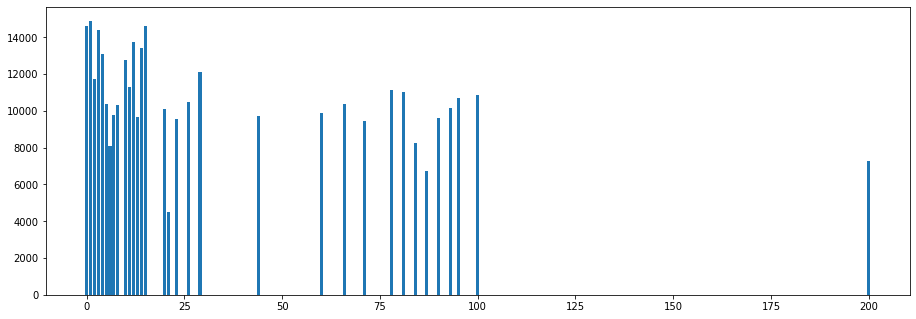

In [156]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0.5,0.5,2,1])
ax.bar(df_f['No of Venues'],df_f['Mean distance'])
plt.show()

We can see here that the nodes with lower number of venues surrounding them have higher mean distances from the venues

9. Now in the next step we would add the Specific Photovoltaic Power Output for these grid stations. Unfortunately there is no dataset available for these values so I had no choice but to make one by entering the coordinates of the grid stations one by one into Global Solar Atlas and getting their PVOUT values. You can also check out data related to solar radiation such as PVOUT, DNI and GHI values for your hometown by searching it. Foolowing is the link
https://globalsolaratlas.info/map?r=PAK&c=30.626947,68.99585,5

All we have to do is get PVOUT values from df_s and assign them to the PVOUT column in df_f

In [60]:
df_s=pd.read_csv(r"E:\Data of old laptop\M.Ali\USB Data\CVs\IBM DS\Capstone Project\DF_Solar1.csv")

In [62]:
df_f['PVOUT']=df_s['PVOUT']

In [63]:
df_f

level_0                            Node name  \
0          0                                 11KV   
1          1             500 KV Transmission line   
2          2                    AES Lalpir 362 MW   
3          3          AES Pak Gen Oil Power Plant   
4          4               Anoud Power Generation   
5          5                    Atlas Power Plant   
6          6    Attock Generation Oil Power Plant   
7          7                               BROTHA   
8          8                          Bahria Town   
9          9                  Balloki Power Plant   
10        10                                Bannu   
11        11                         Bannu 132 KV   
12        12           Bhikki Thermal Power Plant   
13        13                           Bijli Ghar   
14        14                Bin Qasim Power Plant   
15        15                               Burhan   
16        16                            Charsadda   
17        17             Crescent Power Tech Ltd.   
18        18                            D.G. Khan   
19        19                              Daharki   
20        20                            Daud Khel   
21        21        Engro Energy CCGT Power Plant   
22        22    FWEL-I / Mirpur Sakro Power House   
23        23          Fauji Kabirwala Power Plant   
24        24             Foundation Power Company   
25        25                   GEPCO Grid Station   
26        26                               Garden   
27        27                                Gatti   
28        28                           Ghazi Road   
29        29                         Grid Station   
30       111             Grid Station 66 KV FESCO   
31        30                                Guddu   
32        31                Guddu Thermal Station   
33        32     Gul Ahmed Energy Oil Power Plant   
34        33                            Hala Road   
35        34            Hubco Narowal Power Plant   
36        35                    Hubco Power Plant   
37        36                   IESCO Grid Station   
38        37                             Jamshoro   
39        38         Jamshoro Thermal Power Plant   
40        39                    Japan Power Plant   
41        40          Jhimpir Wind Energy Project   
42        41                   Jinnah Power House   
43        42                     Johal Power line   
44        43                             K.D.A-33   
45        44                           KANUPP 2&3   
46        45                             KANUPP-1   
47        46         KESC Korangi Gas Power Plant   
48        47             KESC Korangi Power Plant   
49        48            KESC SITE Gas Power Plant   
50        49                        Kapco 1638 MW   
51        50                             Kassowal   
52        51        Khan Khwar Hydropower Project   
53       112                              Khuzdar   
54        52                 Kohinoor Power Plant   
55        53                   LESCO Grid Station   
56        54                   LESCO Grid Station   
57        55                               Lahore   
58       113              Lakhra Coal Power Plant   
59        56                           Lalsohanra   
60       114                              Loralai   
61        58                                MEPCO   
62        57                                MEPCO   
63        59                           Mangla Dam   
64        60                               Mardan   
65        61                            Master 01   
66        62                               Multan   
67        63                         Muzaffargarh   
68        64                                N.K.I   
69        65                             New Dadu   
70        66                      New Kot Lakhpat   
71        67                 Nishat Power Limited   
72        68                                Okara   
73        69                                  P G   
74        70                  

Now lets analyze the PVOUT values by plotting them against Latitude and Longitude to see how solar radiation varies accross the geography of the country

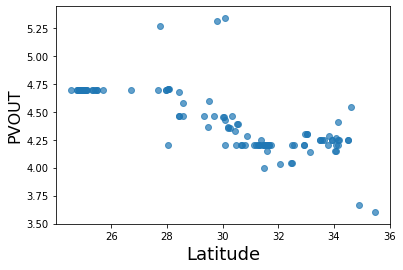

In [164]:
plt.scatter(df_f['Latitude'], df_f['PVOUT'], alpha=0.7)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('PVOUT', fontsize=16)

plt.show()

We can observe that the PVOUT values decrease with increasing latitude. Hence location in the south of Pakistan recieve more sunlight than locations in the north. 

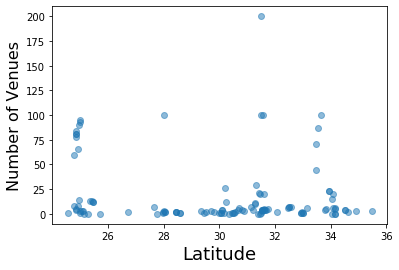

In [166]:
plt.scatter(df_f['Latitude'], df_f['No of Venues'], alpha=0.5)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Number of Venues', fontsize=16)

plt.show()

If we plot the Number of Venues against Latitude, we can observe that there is a greater concenration of nodes and their venues in the norther half of the country. This is because the Northern half of Pakistan is more populated than its souther half

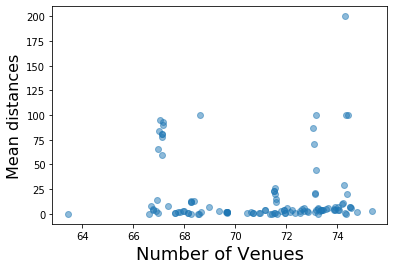

In [167]:
plt.scatter(df_f['Longitude'], df_f['No of Venues'], alpha=0.5)
plt.xlabel('Number of Venues', fontsize=18)
plt.ylabel('Mean distances', fontsize=16)

plt.show()

Also if we plot the Number of Venues against the Longitude, we can see that the number of locations and venues are more concentrated along the eastern half of Pakistan

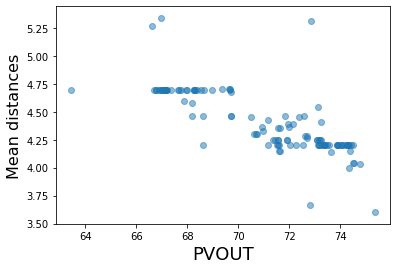

In [169]:
plt.scatter(df_f['Longitude'], df_f['PVOUT'], alpha=0.5)
plt.xlabel('PVOUT', fontsize=18)
plt.ylabel('Mean distances', fontsize=16)

plt.show()

But locations aong the western boundry of Pakistan have higher PVOUT values. Meaning they receive more sunlight!

10. Now lets use K-means clustering to group these sites into cluster and observe the resulting clusters 

Lets drop the categorical variables from the dataframe

In [66]:
df_final=df_f.drop(['level_0','Node name','Description','Latitude','Longitude'], axis=1)

In [67]:
df_final

No of Venues  Mean distance  PVOUT
0              1    7590.000000  4.300
1              2   11580.500000  4.460
2              4    6066.250000  4.425
3              1    2164.000000  4.367
4             81   10183.716049  4.690
5              4   11408.500000  4.200
6             87    6708.804598  4.250
7              4   11629.500000  4.200
8             71    9445.830986  4.250
9              4    4165.750000  4.200
10             2    1642.000000  4.300
11             1    9056.000000  4.300
12             4   13104.750000  4.200
13             7    6321.714286  4.200
14             8    8354.125000  4.690
15             5   10319.600000  4.280
16            20   10106.700000  4.150
17             5   10385.400000  4.200
18             1   12778.000000  4.450
19             2    4254.000000  4.700
20             1    2600.000000  4.200
21             3   10720.000000  4.700
22             1    5472.000000  4.690
23             1   13346.000000  4.390
24             1    7314.000000  4.690
25             7    5243.142857  4.040
26            84    8248.011905  4.690
27            20    8025.950000  4.200
28           100    9324.620000  4.200
29             6    4745.833333  4.040
30             0   14593.000000  4.250
31             2   11688.000000  4.673
32             2   11702.500000  4.460
33            78   11142.294872  4.690
34            13    6936.846154  4.690
35             2   10035.500000  4.030
36             8   10299.625000  4.690
37           100   10864.460000  4.250
38            12   13207.583333  4.690
39            12   13037.666667  4.690
40            29   12091.482759  4.200
41             3    5206.000000  4.690
42             1    5359.000000  4.200
43             4   12437.250000  4.200
44            93   10139.763441  4.690
45             5   10242.400000  4.690
46             4    8658.500000  4.690
47            81   11004.654321  4.690
48            60    9876.183333  4.690
49            66   10358.287879  4.690
50             1    2544.000000  4.325
51             1   13608.000000  4.200
52             3    8828.333333  3.670
53             0   14593.000000  5.270
54            10   12746.200000  4.200
55             1    2787.000000  4.200
56           200    7244.070000  4.200
57             4    9634.750000  4.200
58             0   14593.000000  4.690
59             1    4322.000000  4.367
60             0   14593.000000  4.460
61             2     826.000000  5.310
62             3    3897.333333  4.460
63             6    4679.333333  4.140
64             6    6018.666667  4.200
65             1   12438.000000  4.690
66            12   13732.000000  4.350
67             4    5956.500000  4.200
68            14   13409.928571  4.690
69             2    3327.000000  4.690
70           100    5982.790000  4.200
71             7    9763.428571  4.200
72             4    5685.250000  4.200
73             4    8112.250000  4.250
74            23    8943.478261  4.250
75             0   14593.000000  4.690
76            23    9529.521739  4.250
77             2    6561.500000  4.539
78            95   10688.073684  4.690
79             3    9436.333333  3.600
80             2    4022.000000  4.390
81             3   12467.333333  4.200
82             3    8730.333333  4.460
83             1   14902.000000  5.340
84            44    9688.159091  4.250
85             7    9362.000000  4.690
86             5    8795.000000  4.200
87             4    8423.250000  4.200
88             6    8073.500000  4.200
89            15   14623.800000  4.200
90            20    8217.650000  4.150
91           100    9459.200000  4.200
92             2    4652.500000  4.690
93             7    5244.571429  4.200
94             2    2809.000000  4.600
95             4   11127.750000  4.200
96             4   12583.250000  4.200
97            11   11278.181818  4.200
98            90    9622.088889  4.690
99             4    8119.500000  4.250
100            0   14593.000000  4.690
101            2    2566.5

Now let's normalize the dataset. We use StandardScaler() to normalize our dataset.

In [104]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-3.67670887e-01, -3.70679517e-01, -1.07410084e+00],
       [ 7.09359725e-01,  2.03180933e-01,  1.39001285e+00],
       [-7.78928974e-01,  7.76489593e-02,  1.57956006e-01],
       [-1.83214103e+00, -1.30375454e-01,  1.57956006e-01],
       [ 3.32369605e-01,  1.02810533e+00, -1.07410084e+00],
       [ 6.62937155e-01, -7.29342298e-01, -1.07410084e+00],
       [-6.05504347e-01, -5.50010907e-01,  1.57956006e-01],
       [ 7.22584759e-01, -7.29342298e-01,  1.39001285e+00],
       [ 1.33215413e-01, -5.50010907e-01, -1.07410084e+00],
       [-1.29187138e+00, -7.29342298e-01,  1.57956006e-01],
       [-1.97302813e+00, -3.70679517e-01,  1.57956006e-01],
       [ 2.80005518e-02, -3.70679517e-01, -1.07410084e+00],
       [ 1.12075276e+00, -7.29342298e-01,  1.39001285e+00],
       [-7.09979505e-01, -7.29342298e-01,  1.57956006e-01],
       [-1.61434572e-01,  1.02810533e+00, -1.07410084e+00],
       [ 3.69044502e-01, -4.42412073e-01, -1.07410084e+00],
       [ 3.11583076e-01, -9.08673688e-01

Lets find the optimum K Value for the model by the elbow method

In [114]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_final)
    distortions.append(kmeanModel.inertia_)

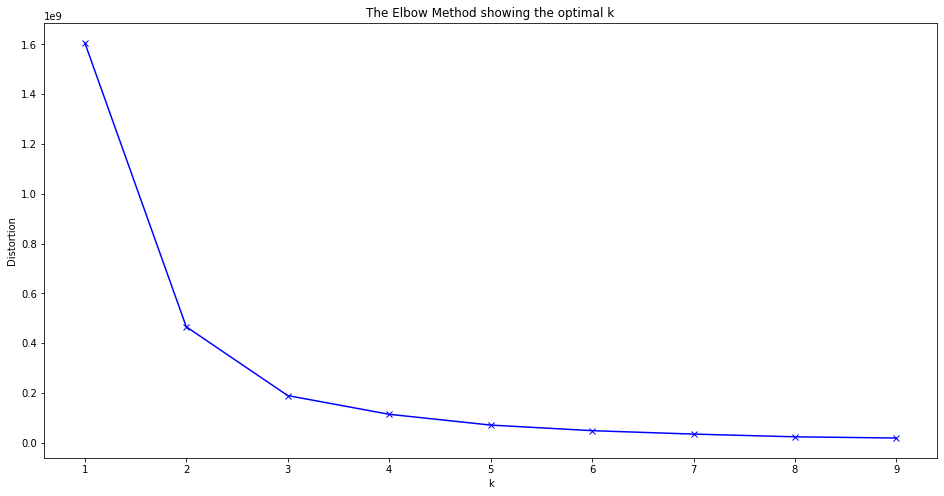

In [115]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As we can observe that the values of k after 3 has minimal impact on the distortion value, we will keep 3 numbers of clusters for the model.

Lets apply k-means on our dataset to generate cluster labels, and take look at cluster labels.

In [105]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 2 0 0 1 1 0 2 1 0 0 1 2 0 1 1 1 1 2 0 0 1 0 2 1 0 1 1 1 0 2 2 2 1 0 1 1
 1 2 2 2 0 0 2 1 1 1 1 1 1 0 2 1 2 2 0 1 1 2 0 2 0 0 0 0 2 2 0 2 0 0 1 0 1
 1 2 1 0 1 1 0 2 1 2 1 1 1 1 1 2 1 1 0 0 0 1 2 1 1 1 2 0 2 0 0 2 0 0 0 0 1
 1 0 2 2 2 2]


In [106]:
df_final["Clus_km"] = labels
df_final.head(5)

No of Venues  Mean distance  PVOUT  Clus_km
0            1    7590.000000  4.300        1
1            2   11580.500000  4.460        2
2            4    6066.250000  4.425        0
3            1    2164.000000  4.367        0
4           81   10183.716049  4.690        1

In [107]:
import matplotlib.pyplot as plt

In [ ]:

plt.scatter(X[:,0],X[:, 1], c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Distance from Venues', fontsize=18)
plt.ylabel('PVOUT', fontsize=16)

plt.show()

Lets examine the clusters by getting their mean values


In [210]:
df_final[df_final['Clus_km']==0].mean()

No of Venues        8.526316
Mean distance    4492.825195
PVOUT               4.406816
Clus_km             0.000000
dtype: float64

In [176]:
df_final[df_final['Clus_km']==1].mean()

No of Venues       34.042553
Mean distance    9495.860348
PVOUT               4.369787
Clus_km             1.000000
dtype: float64

In [177]:
df_final[df_final['Clus_km']==2].mean()

No of Venues         4.375000
Mean distance    13449.408687
PVOUT                4.448531
Clus_km              2.000000
dtype: float64

We can observe that 
1. Cluster 0 has better mean PVOUT, low number of venues but lowest mean distance from venues.
2. Cluster 1 has lowest mean PVOUT highest number of venues but median mean distances.
3. Cluster 2 has highest mean PVOUT, lowest number of venues surrounding the grid stations and hgihest mean distances from the venues.

In [120]:
df_f["Clus_km"] = labels

Now lets plot the custers on a map to see their locations

In [123]:
Cluster_0=df_f[df_f["Clus_km"]==0]

In [124]:
Cluster_1=df_f[df_f["Clus_km"]==1]

In [125]:
Cluster_2=df_f[df_f["Clus_km"]==2]

In [139]:
map_0 = folium.Map(location=[latitude,longitude], zoom_start=6)

# add markers to map
for lat, lng, label in zip(Cluster_0['Latitude'], Cluster_0['Longitude'], Cluster_0['Node name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_0)  
    
map_0

In [133]:
map_1 = folium.Map(location=[latitude,longitude], zoom_start=6)

# add markers to map
for lat, lng, label in zip(Cluster_1['Latitude'], Cluster_1['Longitude'], Cluster_1['Node name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_1)  
    
map_1

In [142]:
map_2 = folium.Map(location=[latitude,longitude], zoom_start=6)

# add markers to map
for lat, lng, label in zip(Cluster_2['Latitude'], Cluster_2['Longitude'], Cluster_2['Node name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_2)  
    
map_2